# Insurance Claim Classification Task

# Table of Contents
* [Problem Statement](#problem_statement)
* [Data Synthesis](#data_synth)
* [Data Exploration and Preprocessing](#eda)
* [Modelling](#model)


# Problem Statement <a id="problem_statement"></a>

### The business would like to understand how we could use a machine learning model to ensure that only 5% of the people they sell a policy to would claim on their policy.

<a id='i1'></a>
### Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import json
import random
from ast import literal_eval
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# 1. Data Synthesis <a id='data_synth'></a>

Task: Synthesise Dataset of 10,000 customers with 40 relevant features that describe their personal and financial characteristics.

The target variable is the binary claim status of 0 or 1.

## A. Choose features

As we're creating a new dataset, the first questions to ask are:

- What is the data representing?
- What attributes might be relevant to predicting claims?

The data will be at the customer level.

Each row will represent an individual customer. Each column will represent an attribute (or feature) of that customer.

During the exploration stage we will decide what features our model will use to predict claims.

Before that though, we have to choose some starting features to explore.

These features relevant to the insurance industry were part researched manually, part generated by a large language model and then reviewed.

I will use the snake case naming convention. eg: num_cars_owned

They are stored in a json file _**"features.json"**_, in the next step we store these features in a data dictionary and export as a more human readable file.

## B. Create Data Dictionary

Storing information about your data and what it represents (metadata) is a necessary process to reduce ambiguity and ensure clear communication between stakeholders.

A data dictionary is a point of reference for understanding what the data represents and helps to answer questions about the data types.

Let's dive into some code.


### Open and read the json file containing our features

In [2]:
with open('features.json', 'r') as file:
    features = json.load(file)

Create library of our features for reference

In [3]:

df_list = []
for feature_type in features.keys():
    df = pd.DataFrame(features[feature_type])
    df['feature_type'] = feature_type
    df_list.append(df)


features_desc = pd.concat(df_list)
features_desc.reset_index(inplace=True)
features_desc.drop('index',axis=1,inplace=True)
features_desc.rename(columns={'name': 'feature'},inplace=True)
features_desc

,feature,description,feature_type
0,age,Customer's age,numerical_features
1,policy_holder_income,Customer's annual income,numerical_features
2,household_income,Stated Household annual income,numerical_features
3,credit_score,Customer's credit score from 300 to 850,numerical_features
4,num_dependents,Number of children or elderly relatives,numerical_features
5,income_per_family_member,Household annual income per family member,numerical_features
6,num_cars_owned,Number of cars owned by the customer,numerical_features
7,home_value,Purchase price of the customer's home,numerical_features
8,mortgage_balance,Current mortgage balance,numerical_features
9,avg_annual_loan_payment,Customer's average annual payment for loans an...,numerical_features


## C. Feature Engineering

Now we have our features, data dictionary and we better understand these features, we need to generate some data.

Python makes it easy to generate random data, but we can take some steps to ensure it makes some sense even though it's random and fake.

As I want the data to work for you like it does for me, I will use a random seed, this means when you run this notebook, you'll get the same random data as I did, so my findings should make sense to you.

First, define a random number generator (**rng**), this will ensure to create random but reproducable data for our features.

The author of this notebook is using '42' as the random seed. Use this number to replicate the data as the author did, or experiment with different seeds.

[What is random seed?](https://medium.com/data-science/random-seeds-and-reproducibility-933da79446e3) - In short, a way to generate random data, but the **same** random data each time. It's like a common starting point for an algorithm everyone can use to get the same result

In [4]:
random_seed = 42 # Edit this if you wish to use different random data

To get the same results, we need to set the seed in each notebook cell. You can test this below, note that the below code always returns the same result

In [5]:
rng = np.random.default_rng(seed=random_seed)
rng.random()

0.7739560485559633

While the next one will always be different as we have not set a seed

In [6]:
rng.random()

0.4388784397520523

To reduce the code we have to write, we can assign our seeded random number generator to a function and call the function instead of re-initializing the seed every time

In [7]:
def seeded_randomness(random_seed=random_seed):
    rng = np.random.default_rng(seed=random_seed)
    return rng

The below should always return 0.7739...

In [8]:
seeded_randomness().random()

0.7739560485559633

Set number of datapoints (10000)

In [9]:
n = 10000

Create an empty dataframe where each column represents a feature

In [10]:
data = pd.DataFrame(columns=features_desc['feature'])

data

feature,age,policy_holder_income,household_income,credit_score,num_dependents,income_per_family_member,num_cars_owned,home_value,mortgage_balance,avg_annual_loan_payment,...,occupation,household_income_source,remote_worker_status,presence_of_pre_existing_condition,home_ownership_status,health_status,driving_record,credit_history_length,postal_code,risks_covered


Now to populate this dataframe with relevant data for each feature. I will do this in stages and generate data for each feature type, starting with the numerical features

### Numerical Features

In [11]:
features_desc[['feature']][features_desc['feature_type'] =='numerical_features']

,feature
0,age
1,policy_holder_income
2,household_income
3,credit_score
4,num_dependents
5,income_per_family_member
6,num_cars_owned
7,home_value
8,mortgage_balance
9,avg_annual_loan_payment


#### Age

If we generate ages completely at random, we might end up with alot more or alot less of a certain age range than is in the general population

To solve this and reflect the real world a little better, we can look up the percentage distribution of age ranges in the UK and generate random ages within each range, where the number of customers in that age range is proportional

These percentages were taken from [gov.uk website](https://www.ethnicity-facts-figures.service.gov.uk/uk-population-by-ethnicity/demographics/age-groups/latest/)

The insurance industry customer base may not reflect this distribution but it gives some logic to our synthesised dataset

In [12]:
age_ranges = pd.read_csv('age-profile-by-ethnicity-table.csv',header=1)

# Get range percentages of adult population based on count, some string slicing required to extract min/max values
age_ranges_adults = age_ranges[['Age brackets','%','Count']].iloc[4:]
age_ranges_adults['Count'] = age_ranges_adults['Count'].str.replace(',','')
age_ranges_adults['percent_of_adult_population'] = age_ranges_adults['Count'].astype('int') / age_ranges_adults['Count'].astype('int').sum()
age_ranges_adults['Low'] = age_ranges_adults['Age brackets'].str[4:6]
age_ranges_adults['High'] = age_ranges_adults['Age brackets'].str[10:12]

# Assign max value to last row
age_ranges_adults.loc[17,'High']= 100

age_ranges_adults

,Age brackets,%,Count,percent_of_adult_population,Low,High
4,Age 18 to 24,8.3,4957265,0.105015,18,24
5,Age 25 to 29,6.5,3901735,0.082655,25,29
6,Age 30 to 34,7.0,4148785,0.087888,30,34
7,Age 35 to 39,6.7,3981630,0.084347,35,39
8,Age 40 to 44,6.3,3755770,0.079563,40,44
9,Age 45 to 49,6.4,3788730,0.080261,45,49
10,Age 50 to 54,6.9,4123455,0.087352,50,54
11,Age 55 to 59,6.8,4029040,0.085352,55,59
12,Age 60 to 64,5.8,3455580,0.073203,60,64
13,Age 65 to 69,4.9,2945140,0.062390,65,69


In [13]:
# Each sublist has [minimum value, maximum value, percentage of total]
age_data_groups =[]

# Set the range and size based on percentage of 10000 (total number of customers in dataset)
for i, row in age_ranges_adults.iterrows():
    age_data_groups.append(seeded_randomness().integers(low=row['Low'], high=row['High'],size=round(n*row['percent_of_adult_population'])))
  

# Bring all ages into one flat list
age_data =  [item for group in age_data_groups for item in group]

Populate dataframe with ages

In [14]:
data['age'] = age_data
data = data.sample(frac=1, random_state=random_seed).reset_index(drop=True)
data.tail()

feature,age,policy_holder_income,household_income,credit_score,num_dependents,income_per_family_member,num_cars_owned,home_value,mortgage_balance,avg_annual_loan_payment,...,occupation,household_income_source,remote_worker_status,presence_of_pre_existing_condition,home_ownership_status,health_status,driving_record,credit_history_length,postal_code,risks_covered
9997,51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9998,48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9999,52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10000,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10001,63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Binning Ages

Technically a preprocessing step, but when synthesising data, I want to ensure some method to the randomess for some features.

I will group (bin) ages into brackets, and use those brackets to generate some data for the income feature that is partially dependant on age.

The income medians per age bracket were cited from [forbes](https://www.forbes.com/uk/advisor/business/average-uk-salary-by-age/)

In [15]:
bins = [17,21,29,39,49,59,max(data['age'])]
labels=['18 - 21', '22 - 29', '30 - 39', '40 - 49', '50 - 59', '60+']
income_medians = [24440,32292,39988,42796,40456,36036]

In [16]:
data['age_brackets'] = pd.cut(data['age'],bins=bins,labels=labels)

#### Policy holder Income (annual salary)

For each age bracket, I will set a range based on the median, this is not meant to be an ideal distribution, but just a method to give some shape to the data

In [17]:
for i, med in enumerate(income_medians):
    #print(i, med)
    income_dist = seeded_randomness(random_seed=random_seed*(i+2)).integers(20000,med+(10000*(i+1)),size=len(data[data['age_brackets'] == labels[i]]))
    data.loc[data['age_brackets'] ==labels[i],'policy_holder_income'] = income_dist

data['policy_holder_income'] = data['policy_holder_income'].astype('int')

#### Household Income (annual)

We can safely assume household income is always equal to or greater than policy holder income

We'll create a random set of multiplication values in the range of 1 (where policy holder is only income provider in household) to 2.5



In [18]:
data['random_multiplication_value_income'] = seeded_randomness().uniform(1,2.5,len(data))

To account for single income households, I'll set a random 30% of these values to 1

In [19]:
random_indices_A = data.sample(frac=0.3,random_state=random_seed*37).index
data.loc[random_indices_A, "random_multiplication_value_income"] = 1

Then multiply policy holder income by that value to get consistent values for Household income

In [20]:
data['household_income'] = round(data['policy_holder_income'] * data['random_multiplication_value_income']).astype('int')

data[['policy_holder_income','random_multiplication_value_income','household_income']].head()

feature,policy_holder_income,random_multiplication_value_income,household_income
0,28761,2.160934,62151
1,36912,1.000000,36912
2,29784,1.000000,29784
3,65331,2.046052,133671
4,59875,1.141266,68333


#### Note on Shuffling

To ensure we have a good mix of labels, I'll shuffle the data after each feature addition, this way we avoid unwanted feature dependencies when our number of possible values are low for features

To ensure the data is shuffled in a new way, a different multiplier can be applied to the seed


In [21]:
def shuffle(multiplier,data):
    data = data.sample(frac=1, random_state=random_seed*multiplier).reset_index(drop=True)
    return data
data = shuffle(2,data)
data.head()

feature,age,policy_holder_income,household_income,credit_score,num_dependents,income_per_family_member,num_cars_owned,home_value,mortgage_balance,avg_annual_loan_payment,...,remote_worker_status,presence_of_pre_existing_condition,home_ownership_status,health_status,driving_record,credit_history_length,postal_code,risks_covered,age_brackets,random_multiplication_value_income
0,60,76604,76604,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60+,1.000000
1,25,27926,40215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22 - 29,1.440063
2,50,56324,107730,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50 - 59,1.912676
3,77,43502,84316,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60+,1.938217
4,56,56332,113860,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50 - 59,2.021234


#### Remaining numerical features

The remaining numerical features we will populate with random data within a range appropriate to that feature

Note: As the rest of the features will be synthesised mostly at random, we may see some things that don't reflect the real world,

such as an 18 year old with an occupation of medical , or mortgage balances that don't align with household income

This is acknowledged, but for the purpose of demonstrating the benefits of machine learning, the dataset will be sufficient despite such anomalies.

In [22]:
features_desc[features_desc['feature_type'] == 'numerical_features']

,feature,description,feature_type
0,age,Customer's age,numerical_features
1,policy_holder_income,Customer's annual income,numerical_features
2,household_income,Stated Household annual income,numerical_features
3,credit_score,Customer's credit score from 300 to 850,numerical_features
4,num_dependents,Number of children or elderly relatives,numerical_features
5,income_per_family_member,Household annual income per family member,numerical_features
6,num_cars_owned,Number of cars owned by the customer,numerical_features
7,home_value,Purchase price of the customer's home,numerical_features
8,mortgage_balance,Current mortgage balance,numerical_features
9,avg_annual_loan_payment,Customer's average annual payment for loans an...,numerical_features


In [23]:
# Credit Score
data['credit_score'] = seeded_randomness(random_seed=random_seed*123).integers(300,851,size=len(data))
data = shuffle(5,data)

# Number Dependents
data['num_dependents'] = seeded_randomness(random_seed=random_seed*234).integers(0,7,size=len(data))
data = shuffle(6,data)

data['income_per_family_member'] =  round(data['household_income'] / (data['num_dependents']+1)) # Add 1 for the policy holder
data = shuffle(7,data)

data['num_cars_owned'] = seeded_randomness(random_seed=random_seed*345).integers(0,4,size=len(data))
data = shuffle(8,data)

data['home_value'] = seeded_randomness(random_seed=random_seed*456).integers(180000,2000000,size=len(data))
data = shuffle(9,data)

data['mortgage_balance'] = seeded_randomness(random_seed=random_seed*678).integers(10000,900000,size=len(data))
data = shuffle(10,data)

data['avg_annual_loan_payment'] = seeded_randomness(random_seed=random_seed*789).integers(500,30000,size=len(data))
data = shuffle(11,data)

data['credit_utilization_ratio'] = seeded_randomness(random_seed=random_seed*321).integers(2,80,size=len(data)) /100
data = shuffle(12,data)

data['years_with_credit_card_issuer'] = seeded_randomness(random_seed=random_seed*987).integers(1,40,size=len(data))
data = shuffle(13,data)

data['avg_monthly_phone_bill'] = seeded_randomness(random_seed=random_seed*876).integers(15,100,size=len(data))
data = shuffle(14,data)

data['annual_medical_expenses'] = seeded_randomness(random_seed=random_seed*654).integers(500,10000,size=len(data))
data = shuffle(15,data)

data['total_life_insurance_coverage'] = data['policy_holder_income'] *10
data = shuffle(16,data)

data['average_commute_time'] = seeded_randomness(random_seed=random_seed*543).integers(15,90,size=len(data))
data = shuffle(17,data)

data['height'] = seeded_randomness(random_seed=random_seed*432).integers(145,205,size=len(data))
data = shuffle(18,data)

data['weight'] = seeded_randomness(random_seed=random_seed*925).integers(110,300,size=len(data))
data = shuffle(19,data)

data['years_of_home_ownership'] = seeded_randomness(random_seed=random_seed*472).integers(1,50,size=len(data))
data = shuffle(20,data)

data['debt_to_income_ratio'] = seeded_randomness(random_seed=random_seed*617).integers(1,75,size=len(data))/100
data = shuffle(21,data)

data['credit_history_length'] = seeded_randomness(random_seed=random_seed*13).integers(1,41,size=len(data)).astype('object')
data = shuffle(32,data)

data.head()

feature,age,policy_holder_income,household_income,credit_score,num_dependents,income_per_family_member,num_cars_owned,home_value,mortgage_balance,avg_annual_loan_payment,...,remote_worker_status,presence_of_pre_existing_condition,home_ownership_status,health_status,driving_record,credit_history_length,postal_code,risks_covered,age_brackets,random_multiplication_value_income
0,62,71706,77742,584,4,15548.0,0,508762,660670,3338,...,NaN,NaN,NaN,NaN,NaN,6,NaN,NaN,60+,1.084181
1,96,63919,157157,331,4,31431.0,1,1073338,203173,11079,...,NaN,NaN,NaN,NaN,NaN,10,NaN,NaN,60+,2.458693
2,42,22477,44700,787,6,6386.0,1,1793081,69085,14073,...,NaN,NaN,NaN,NaN,NaN,38,NaN,NaN,40 - 49,1.988700
3,78,87635,170750,436,4,34150.0,2,461684,210578,15611,...,NaN,NaN,NaN,NaN,NaN,11,NaN,NaN,60+,1.948424
4,37,69047,69772,835,1,34886.0,0,359028,250621,4322,...,NaN,NaN,NaN,NaN,NaN,38,NaN,NaN,30 - 39,1.010494


### Categorical Features

In [24]:
features_desc[features_desc['feature_type'] == 'categorical_features']

,feature,description,feature_type
20,gender,Customer's gender (male/female),categorical_features
21,marital_status,"Customer's marital status (single, married)",categorical_features
22,education_level,"Customer's education level (high school, some ...",categorical_features
23,occupation,Customer's occupation (job type or industry),categorical_features
24,household_income_source,Customer's household income source (self-emplo...,categorical_features
25,remote_worker_status,"(Onsite, Remote, Hybrid) If the customer prima...",categorical_features
26,presence_of_pre_existing_condition,Yes/No if the customer has a pre-existing medi...,categorical_features
27,home_ownership_status,"Customer's home ownership status (owned, rente...",categorical_features


For categories, we can define the labels, assign a number to them, then generate random numbers within that range

#### Gender

In [25]:
data['gender'] = seeded_randomness(random_seed=random_seed*932).integers(1,3,size=len(data)).astype('object')
data = shuffle(22,data)
data['gender'].value_counts()

gender
1    5035
2    4967
Name: count, dtype: int64

Now to label the values

In [26]:
data.loc[data['gender'] == 1, 'gender'] = 'Female'
data.loc[data['gender'] == 2, 'gender'] = 'Male'

data['gender'].value_counts()

gender
Female    5035
Male      4967
Name: count, dtype: int64

#### Marital Status

Lets skew the data so it's not 50/50 and have a 65/35 split of married to single

In [27]:
random_indices_B = data.sample(frac=0.35,random_state=random_seed*38).index

data.loc[random_indices_B,'marital_status'] = 'single'
data.loc[data['marital_status'] != 'single','marital_status'] = 'married'

data = shuffle(23,data)

data['marital_status'].value_counts()

marital_status
married    6501
single     3501
Name: count, dtype: int64

#### Education Level

Use our random number generator and then assign labels

In [28]:
data['education_level'] = seeded_randomness(random_seed=random_seed*4).integers(1,4,size=len(data)).astype('object') # Customer's education level (high school, bachelor's degree, graduate degree)
data = shuffle(24,data)

data.loc[data['education_level'] ==1,'education_level'] = 'High School'
data.loc[data['education_level'] ==2,'education_level'] = 'College Graduate'
data.loc[data['education_level'] ==3,'education_level'] = 'Post Graduate'

data['education_level'].value_counts()

education_level
College Graduate    3362
Post Graduate       3353
High School         3287
Name: count, dtype: int64

#### Occupation

Lets read in a pre-made list of occupations

In [29]:
with open('jobs.json', 'r') as file:
    jobs = json.load(file)

In [30]:
len(jobs['occupations'])

100

In [31]:
data['occupation'] = seeded_randomness().integers(1,100,size=len(data)).astype('object')
data = shuffle(25,data)
for i, val in enumerate(jobs['occupations']):
    data.loc[data['occupation'] == i,'occupation'] = val


data['occupation'].value_counts()



occupation
Dog Trainer             127
Sales Representative    122
Clown                   122
Physical Therapist      122
Music Teacher           119
                       ... 
Pilot                    81
Painter                  80
Librarian                78
Paralegal                75
Culinary Artist          70
Name: count, Length: 99, dtype: int64

Repeat for the remaining categorical features

In [32]:
data['home_ownership_status'] = seeded_randomness(random_seed=random_seed*5).integers(1,3,size=len(data)).astype('object')
data = shuffle(26,data)
data.loc[data['home_ownership_status'] == 1,'home_ownership_status'] = 'Renting'
data.loc[data['home_ownership_status'] == 2,'home_ownership_status'] = 'Homeowner'



data['household_income_source'] = seeded_randomness(random_seed=random_seed*6).integers(1,3,size=len(data)).astype('object')
data = shuffle(27,data)
data.loc[data['household_income_source'] == 1,'household_income_source'] = 'Self Employed'
data.loc[data['household_income_source'] == 2,'household_income_source'] = 'Employee'



data['remote_worker_status'] = seeded_randomness(random_seed=random_seed*7).integers(1,4,size=len(data)).astype('object')
data = shuffle(28,data)
data.loc[data['remote_worker_status'] == 1,'remote_worker_status'] = 'Remote'
data.loc[data['remote_worker_status'] == 2,'remote_worker_status'] = 'Onsite'
data.loc[data['remote_worker_status'] == 3,'remote_worker_status'] = 'Hybrid'




data['presence_of_pre_existing_condition'] = seeded_randomness(random_seed=random_seed*8).integers(1,3,size=len(data)).astype('object')
data = shuffle(29,data)
data.loc[data['presence_of_pre_existing_condition'] == 1, 'presence_of_pre_existing_condition'] = 'Yes'
data.loc[data['presence_of_pre_existing_condition'] == 2, 'presence_of_pre_existing_condition'] = 'No'




### Other Features

#### Ordinal Features

In [33]:
data['health_status'] = seeded_randomness(random_seed=random_seed*9).integers(1,5,size=len(data)).astype('object')
data = shuffle(30,data)
data.loc[data['health_status'] == 1,'health_status'] = 'Excellent'
data.loc[data['health_status'] == 2,'health_status'] = 'Good'
data.loc[data['health_status'] == 3,'health_status'] = 'Fair'
data.loc[data['health_status'] == 4,'health_status'] = 'Poor'


data['driving_record'] = seeded_randomness(random_seed=random_seed*12).integers(1,5,size=len(data)).astype('object')
data = shuffle(31,data)
data.loc[data['driving_record'] == 1,'driving_record'] = 'No Penalties'
data.loc[data['driving_record'] == 2,'driving_record'] = 'Single Accident'
data.loc[data['driving_record'] == 3,'driving_record']= 'Multiple Accidents'
data.loc[data['driving_record'] == 4,'driving_record'] = 'DUI/Serious Offence'

#### Geographic features

In [34]:
data['postal_code'] = seeded_randomness(random_seed=random_seed*15).integers(1,125,size=len(data))
data = shuffle(33,data)

#### Coverage Features

This refers to the "risks_covered" feature in our data dictionary, I will represent this by separating each risk into it's own feature and assigning a value of 1 or 0

In [35]:
types_of_coverage = ['health','life','car','motorcycle','home','travel','pet','hazardous_activity']

for i, cov in enumerate(types_of_coverage):
    data[cov] = seeded_randomness(random_seed=random_seed+(i*(i+2))).integers(0,2,size=len(data))
    data = shuffle(34+i,data)

### Define the predicted (y) variable

We're trying to predict if a customer will claim in their first year. This is known as a binary classification problem. The answer can be framed as True (1) or False (0):

- A value of **1** represents that a claim was made in the first year
- A value of **0** represents that **no** claim was made during the first year

We can use our random number generator to assign these values

In [36]:
data['claim_filed_in_first_year'] = seeded_randomness(random_seed=random_seed**2).integers(0,2,size=len(data))
data = shuffle(50,data)
data['claim_filed_in_first_year'].value_counts()

claim_filed_in_first_year
0    5011
1    4991
Name: count, dtype: int64

In reality, this is unlikely to be a 50/50 chance, lets first set this value to 0 and add some claims for specific values of features to synthesise some patterns

Start by assigning everything as 0

In [37]:
data['claim_filed_in_first_year'] = 0
data['claim_filed_in_first_year'].value_counts()

claim_filed_in_first_year
0    10002
Name: count, dtype: int64

Declare our X and Y features for easy reference

In [38]:
selected_features = ['age',
'policy_holder_income',
'household_income',
'credit_score',
'num_dependents',
'income_per_family_member',
'num_cars_owned',
'home_value',
'mortgage_balance',
'avg_annual_loan_payment',
'debt_to_income_ratio',
'credit_utilization_ratio',
'years_with_credit_card_issuer',
'avg_monthly_phone_bill',
'annual_medical_expenses',
'total_life_insurance_coverage',
'average_commute_time',
'height',
'weight',
'years_of_home_ownership',
'gender',
'marital_status',
'education_level',
'occupation',
'household_income_source',
'remote_worker_status',
'presence_of_pre_existing_condition',
'home_ownership_status',
'health_status',
'driving_record',
'credit_history_length',
'postal_code',
'health',
'life',
'car',
'home',
'travel',
'motorcycle',
'pet', 
'hazardous_activity']

predicted_variable = 'claim_filed_in_first_year'

Dropping the additional helper columns

In [39]:
for value in data.columns:
    if value not in features_desc.feature.unique():
        print(value)

age_brackets
random_multiplication_value_income
health
life
car
motorcycle
home
travel
pet
hazardous_activity
claim_filed_in_first_year


### Cleanup

Some features may need to be adjusted to make more practical sense

If Home Ownership Status = Renting, some of the other features like Mortgage balance and Home value should be adjusted

In [40]:

data.loc[data['home_ownership_status'] == 'Renting', 'home_value'] = 0
data.loc[data['home_ownership_status'] == 'Renting', 'mortgage_balance'] = 0
data.loc[data['home_ownership_status'] == 'Renting', 'years_of_home_ownership'] = 0
data[['home_ownership_status','home_value','mortgage_balance','years_of_home_ownership']][data['home_ownership_status'] == 'Renting'].value_counts()

home_ownership_status  home_value  mortgage_balance  years_of_home_ownership
Renting                0           0                 0                          5040
Name: count, dtype: int64

# Synthesise Linear relationships and trends

To better show the benefits of machine learning in our model, I will build in some linear relationships and trends into our synthesised data

## 1. Include a relationship between income and phone bill

As we're just synthesising this data we can make phone bill a fraction of income

Lets assume phone bill is between 1% and 3% of monthly income

In [41]:
data['random_multiplication_value_phone'] = seeded_randomness().uniform(0.009,0.031,len(data))
data['avg_monthly_phone_bill'] = (data['policy_holder_income'] / 12) * data['random_multiplication_value_phone']

## 2. Add more claims for customers within the mid range of debt to income ratio

In [42]:
debt_condition_no_claim = data[(data['debt_to_income_ratio'] >=0.3)&(data['debt_to_income_ratio']<=0.5)&(data[predicted_variable] == 0)]

random_indices_C = debt_condition_no_claim.sample(frac=0.3,random_state=random_seed*33).index

data.loc[random_indices_C,predicted_variable] = 1

## 3. Add more claims for customers with motorcycle coverage

In [43]:
no_motorcyle_1_claim = data.loc[(data['motorcycle'] == 0) &(data[predicted_variable] == 1 ),predicted_variable]
indices_to_adjust_A = no_motorcyle_1_claim.sample(frac=0.3,random_state=random_seed).index


data.loc[indices_to_adjust_A, 'motorcycle'] = 1

## 4. More claims for mid-range commute time

Lets assume, if your commute is between 40 and 60 minutes, you have more claims

In [44]:
commute_bins = [14,30,60,90]
data['commute_time_range'] = pd.cut(data.average_commute_time,bins=commute_bins,labels=['15-30','31-60','> 1hr'])

In [45]:
mid_range_commute_no_claim = data.loc[(data['commute_time_range'] == '31-60') &(data[predicted_variable] == 0 ),predicted_variable]

indices_to_adjust_B = mid_range_commute_no_claim.sample(frac=0.15,random_state=random_seed).index


data.loc[indices_to_adjust_B, predicted_variable] = 1

## 5. Add More claims as num of dependents increases

For each num_dependent value, take a sample of rows where claim = 0 and change to 1, increase the percentage sample by 2% for each additional dependent

In [46]:
for i, value in enumerate(data.num_dependents.sort_values().unique()):
    num_dep_filter = data.loc[(data['num_dependents'] == value)&(data['claim_filed_in_first_year']==0)]
    indices_to_adjust_C = num_dep_filter.sample(frac=(i/100),random_state=random_seed).index
    data.loc[indices_to_adjust_C, predicted_variable] = 1

## 8. More claims for poor health status

Take a sample of customers with poor health where claim = 0 and change to 1

In [47]:
poor_health_no_claim = data.loc[(data['health_status'] == 'Poor') &(data[predicted_variable] == 0 ),predicted_variable]
indices_to_adjust_D = poor_health_no_claim.sample(frac=0.2,random_state=random_seed).index


data.loc[indices_to_adjust_D, predicted_variable] = 1

## 9. More claims for bad driving record

Take a sample of customers with dangerous driving where claim = 0 and change to 1

In [48]:
serious_offence_no_claim = data.loc[(data['driving_record'] == 'DUI/Serious Offence') &(data[predicted_variable] == 0 ),predicted_variable]
indices_to_adjust_E = serious_offence_no_claim.sample(frac=0.07,random_state=random_seed).index


data.loc[indices_to_adjust_E, predicted_variable] = 1

## 10. Add more claims for certain postal areas

Higher occurrence of claims may occur in specific geographic locations, lets build this into our data

In [49]:
post_code_selection = data[data['postal_code'].isin(data.postal_code.value_counts().head(7).index)&(data[predicted_variable]==0)]
random_indices_D = post_code_selection.sample(frac=0.70,random_state=random_seed*82).index

data.loc[random_indices_D,predicted_variable] =1

Now let's check how many customers had claims in the first year

In [50]:
data.claim_filed_in_first_year.value_counts()

claim_filed_in_first_year
0    7430
1    2572
Name: count, dtype: int64

Now lets add some claims at random

In [51]:
random_claims = data[(data[predicted_variable]==0)]
random_indices_E = random_claims.sample(frac=0.03,random_state=random_seed*88).index

data.loc[random_indices_E,predicted_variable] =1

In [52]:
data.claim_filed_in_first_year.value_counts()

claim_filed_in_first_year
0    7207
1    2795
Name: count, dtype: int64

<Axes: xlabel='claim_filed_in_first_year'>

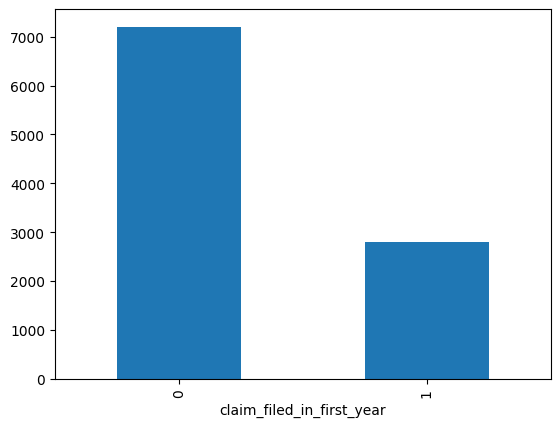

In [53]:
data.claim_filed_in_first_year.value_counts().plot(kind='bar')

#### Check for null values

The only feature with null values is the risks_covered feature, which has been accounted for in the health, life, car, motorcycle, home, travel and pet categories

So our dataset is now synthesised

In [54]:
data.isnull().any().sort_values(ascending=False)

feature
risks_covered                          True
age                                   False
random_multiplication_value_income    False
remote_worker_status                  False
presence_of_pre_existing_condition    False
home_ownership_status                 False
health_status                         False
driving_record                        False
credit_history_length                 False
postal_code                           False
age_brackets                          False
health                                False
policy_holder_income                  False
life                                  False
car                                   False
motorcycle                            False
home                                  False
travel                                False
pet                                   False
hazardous_activity                    False
claim_filed_in_first_year             False
random_multiplication_value_phone     False
household_income_source 

### Duplicates and Missing Values - I will explain how I would handle these cases, but won't demonstrate in the notebook

#### Duplicates

In reality duplicates may not be as obvious as the same id appearing more than once, you may notice 2 different customer ids have the same name, address and date of birth, and logically assume it's the same person.

You can identify duplicates using pandas drop_duplicates method and selecting a subset of columns

But if there are many duplicates in your data, a conversation should be had about how that data is being loaded from your source system eg: consumers purchasing policies online or via call centre

When handling duplicates, we have to decide:

1. Do we remove one of the duplicate rows and if so, which values do we keep for the given features?
2. Do we remove all rows which are duplicated, as the presence of duplicates means those datapoints cannot be trusted?

The answer to these questions will depend on the specific use case. For this exercise, I would likely remove all duplicates if they consisted of < 5% of my entire dataset.

Otherwise I would assess which features the duplicated rows differed on and make an estimate on which duplicate row had the value that made most sense, keeping that row.

-------------------------

#### Missing Values

Like duplicates, when values are missing we should address this by looking at the source system and fixing the root cause. But when there are missing values in your data and you have ruled out any possibility of getting the correct values, you can do one of 2 things:

1. Impute the missing values with a logical proxy value
2. Remove any rows with missing values

Depending on which features have missing values, you may do a combination of these options for different features.

For imputation, take any logical steps such as if number of dependents was missing, but I have household_income and income_per_family_member, we could use these 2 featires to logically compute num_dependents

In other cases we may take an average of data for similar customers. But we should be careful when doing this and ensure we label any rows as proxy values so we can check the impact of such proxy data on our final model. When imputing an average we may consider using the median value as this is less bias towards outliers in the data than the mean.

If the number of rows with missing values is small, I would consider removing these from our training data altogeather as imputation may not be worth the tradeoff of using proxy values

------------------------------------------------
Our dataset is generated, now we can explore it

# 2. Data Exploration and Preprocessing <a id='eda'></a>

We can see some summary statistics very quickly

In [55]:
data.describe()

feature,age,policy_holder_income,household_income,credit_score,num_dependents,income_per_family_member,num_cars_owned,home_value,mortgage_balance,avg_annual_loan_payment,...,health,life,car,motorcycle,home,travel,pet,hazardous_activity,claim_filed_in_first_year,random_multiplication_value_phone
count,10002.000000,10002.000000,10002.000000,10002.000000,10002.000000,10002.000000,10002.000000,1.000200e+04,10002.000000,10002.000000,...,10002.000000,10002.000000,10002.000000,10002.000000,10002.000000,10002.000000,10002.000000,10002.000000,10002.000000,10002.000000
mean,48.686063,49436.348430,75132.355529,575.837033,3.041892,27226.593781,1.509798,5.359973e+05,226792.204059,15288.320536,...,0.493801,0.495501,0.501700,0.516497,0.502899,0.494801,0.504199,0.499800,0.279444,0.019938
std,19.164193,20267.834185,40739.275290,158.995633,1.987146,27742.783379,1.115361,6.531618e+05,291179.919541,8525.088223,...,0.499987,0.500005,0.500022,0.499753,0.500017,0.499998,0.500007,0.500025,0.448749,0.006341
min,18.000000,20001.000000,20001.000000,300.000000,0.000000,2901.000000,0.000000,0.000000e+00,0.000000,507.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009007
25%,32.000000,31773.750000,44737.500000,438.000000,1.000000,10595.750000,1.000000,0.000000e+00,0.000000,7974.750000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014413
50%,48.000000,46562.000000,65763.000000,575.000000,3.000000,17542.000000,2.000000,0.000000e+00,0.000000,15290.500000,...,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.019964
75%,63.000000,65070.000000,94664.750000,714.000000,5.000000,32278.000000,3.000000,1.074049e+06,454952.750000,22779.250000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.025405
max,99.000000,96032.000000,231645.000000,850.000000,6.000000,219211.000000,3.000000,1.999403e+06,899474.000000,29997.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.030999


In [56]:
data.describe(include=['object'])

feature,gender,marital_status,education_level,occupation,household_income_source,remote_worker_status,presence_of_pre_existing_condition,home_ownership_status,health_status,driving_record,credit_history_length,risks_covered
count,10002,10002,10002,10002,10002,10002,10002,10002,10002,10002,10002,0
unique,2,2,3,99,2,3,2,2,4,4,40,0
top,Female,married,College Graduate,Dog Trainer,Self Employed,Hybrid,No,Renting,Excellent,Single Accident,26,NaN
freq,5035,6501,3362,127,5094,3351,5039,5040,2533,2538,280,NaN


To aid the data exploration, let's encode our categorical variables

In [57]:
data['gender'] = pd.factorize(data['gender'])[0]
data['marital_status'] = pd.factorize(data['marital_status'])[0]
data['education_level'] = pd.factorize(data['education_level'])[0]
data['occupation'] = pd.factorize(data['occupation'])[0]
data['household_income_source'] = pd.factorize(data['household_income_source'])[0]
data['remote_worker_status'] = pd.factorize(data['remote_worker_status'])[0]
data['presence_of_pre_existing_condition'] = pd.factorize(data['presence_of_pre_existing_condition'])[0]
data['home_ownership_status'] = pd.factorize(data['home_ownership_status'])[0]
data['health_status'] = pd.factorize(data['health_status'])[0]
data['driving_record'] = pd.factorize(data['driving_record'])[0]
data['home_ownership_status'] = pd.factorize(data['home_ownership_status'])[0]
data['commute_time_range'] = pd.factorize(data['commute_time_range'])[0]
data['age_brackets'] = pd.factorize(data['age_brackets'])[0]



### A. Exploratory Data Analysis

In this step we look for patterns in the data to help decide how to model it

I'll use 3 techniques to decide on which features to use in the model

1. Pairplot
2. Correlation Heatmap
3. Histplots

#### 1. Pairplot

A pairplot is useful for visualising many features at once, with the goal of narrowing down the most important ones.

We can also look for linear relationships between predictor features

When predictor variables are highly correlated, it's more difficult their impact on the predicted variable

Best practice is to remove one of the correlated variable from the final model

For example here, policy_holder_income, household_income and monthly_phone_bill have clear linear relationships, so I would likely not use all of them in the model

We can also see debt to income ratio has a concentration of positive (claim) values in the centre of it's distribution

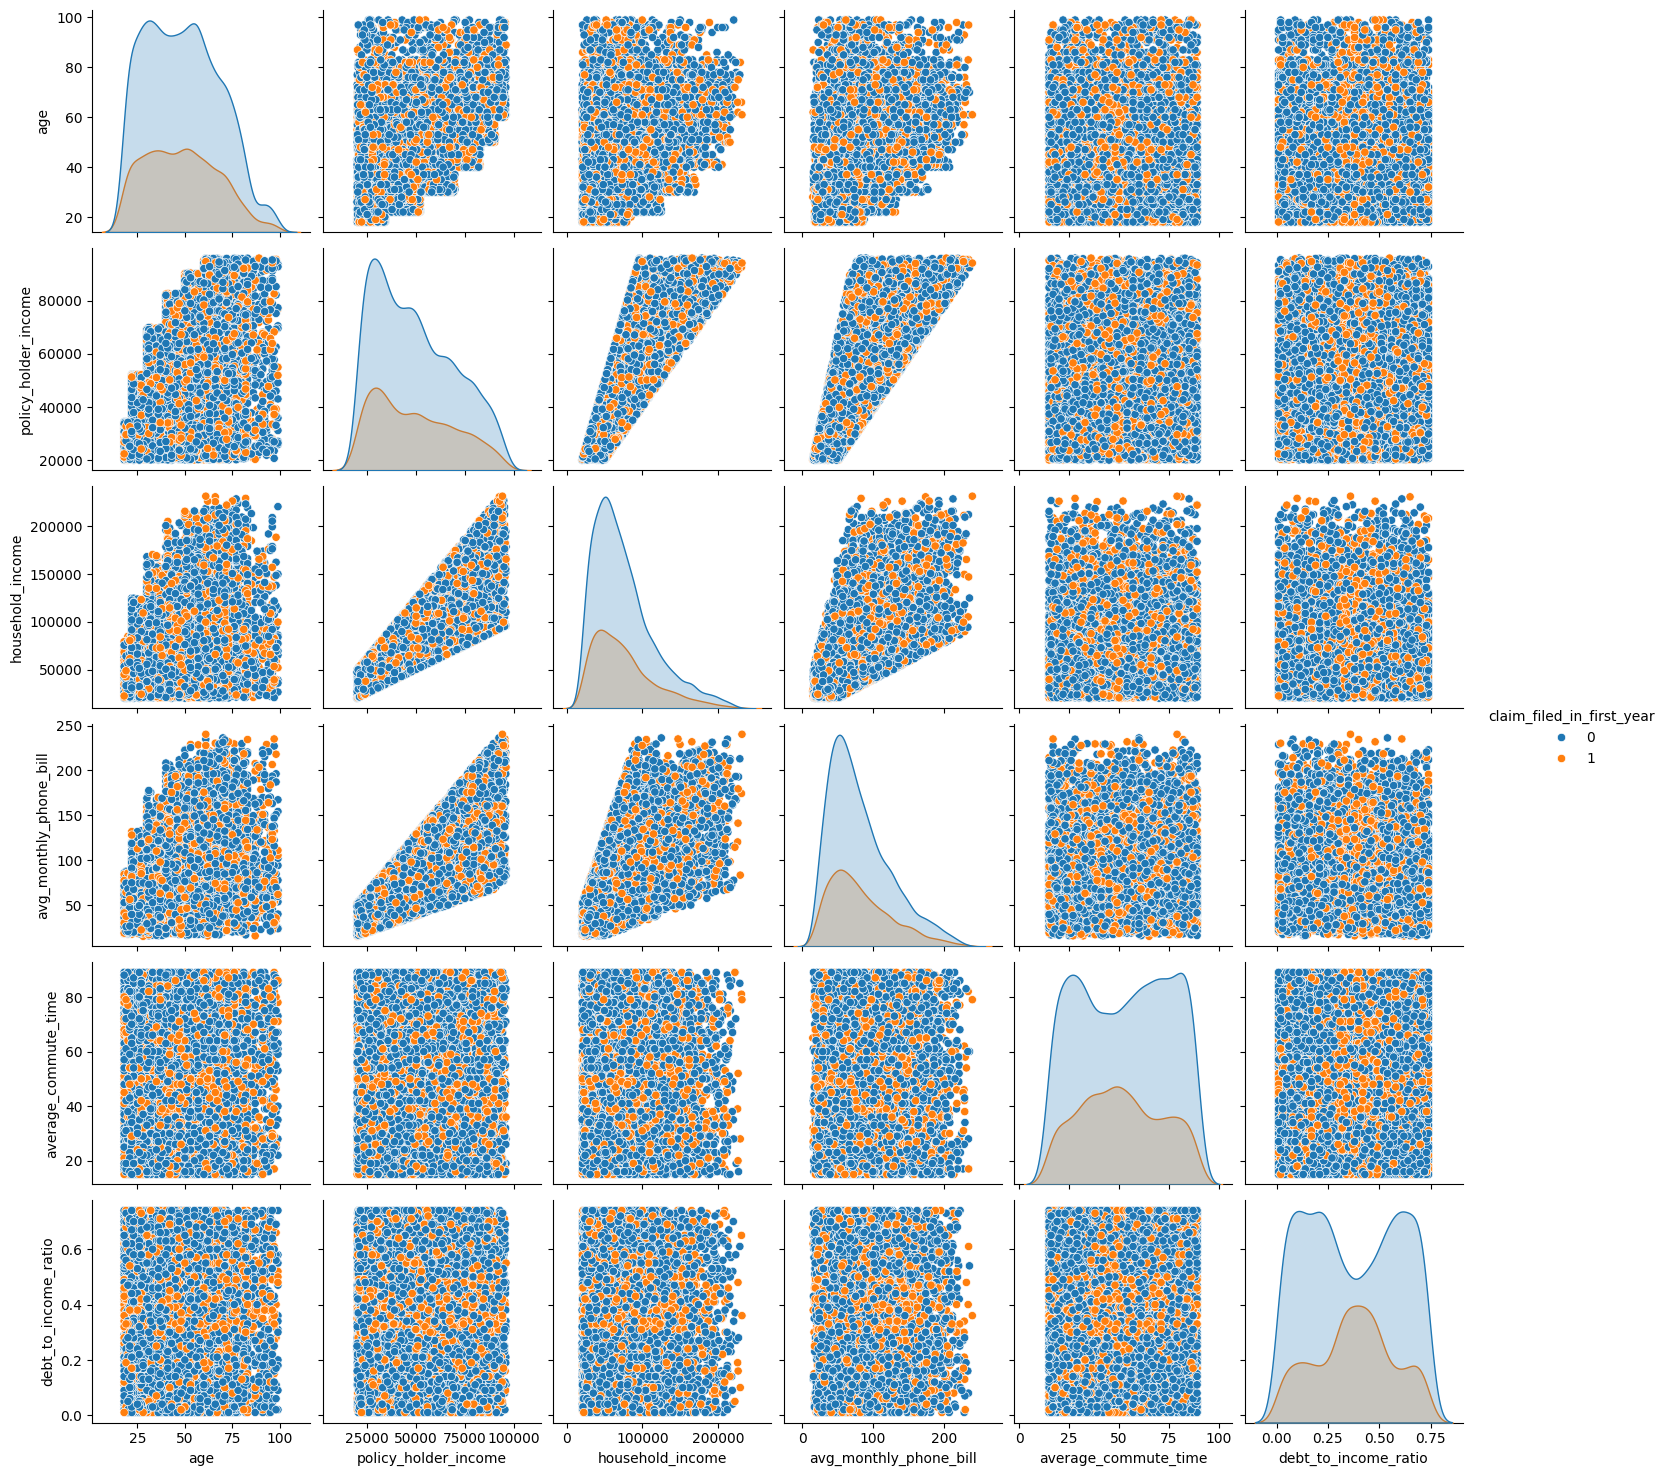

In [58]:
sns.pairplot(data[['age', 'policy_holder_income','household_income','avg_monthly_phone_bill','average_commute_time','debt_to_income_ratio',predicted_variable]],hue=predicted_variable)

#### 2. Heatmap

Use heatmap to identify correlated features

Features with high correlation to the target variable are good candidates for use in a model

As the heatmap shows, there are no correlated features with the target variable due to the mostly random nature of the dataset

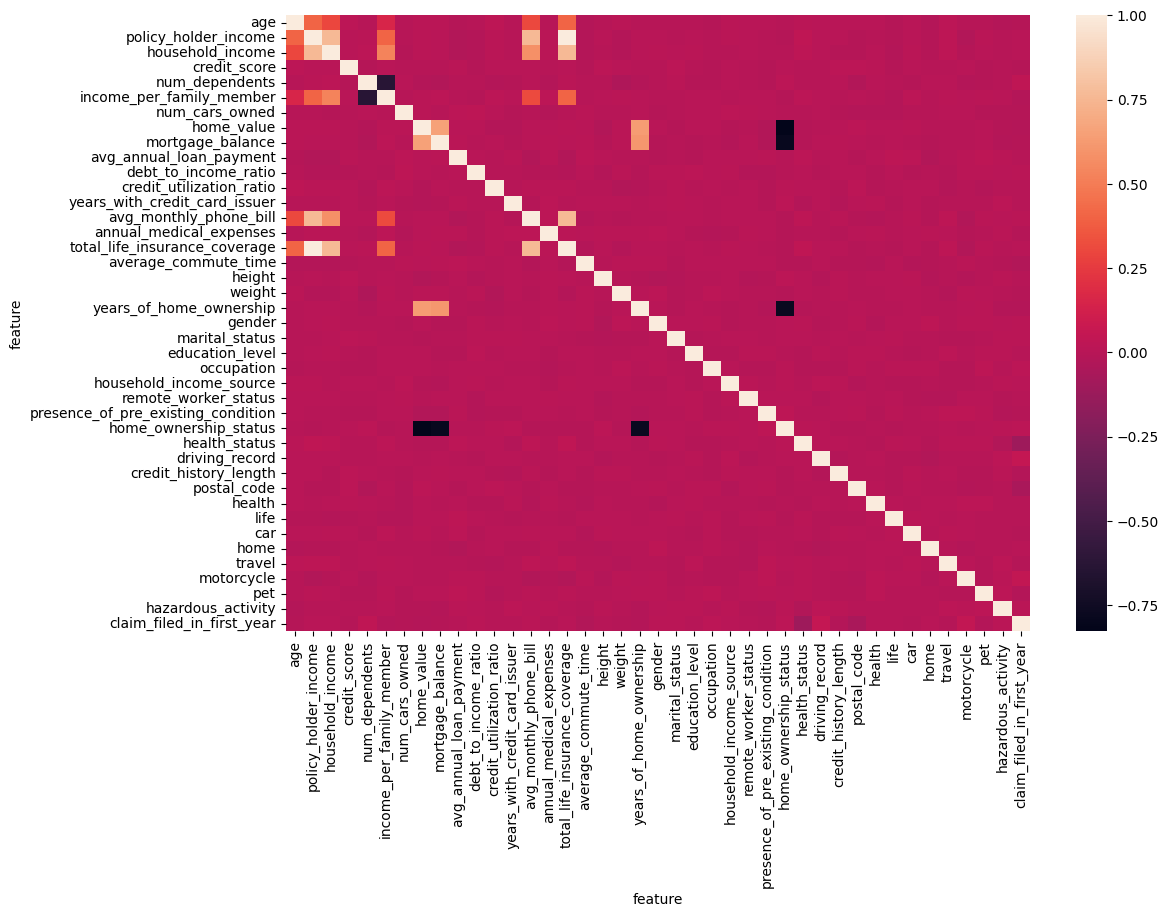

In [59]:
plt.figure(figsize=(12,8))
sns.heatmap(data[selected_features+[predicted_variable]].corr())

plt.show()

#### 3. Stacked Histograms

Lets see the observation counts of feature values against the target variable.

If there are more instances of the target variable within a certain group, we can infer that the feature of this group is predictive and would be valuable to a model

There are more claims in the mid-range of the debt to income ratio, so there is some value in this feature

<Axes: xlabel='debt_to_income_ratio', ylabel='Count'>

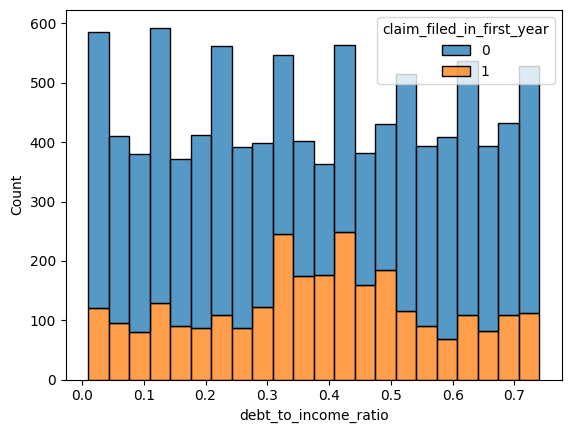

In [60]:
sns.histplot(data,x='debt_to_income_ratio',hue=predicted_variable,multiple="stack")

There are no significant patterns with regard to income

<Axes: xlabel='policy_holder_income', ylabel='Count'>

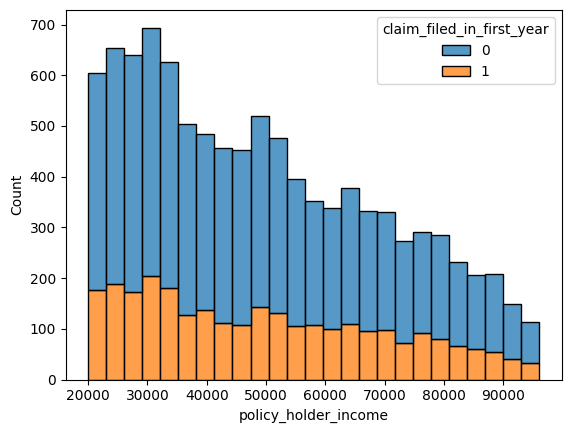

In [61]:
sns.histplot(data,x='policy_holder_income',hue=predicted_variable,multiple="stack")

The number of claims is slightly higher in the mid range of commute times

<Axes: xlabel='average_commute_time', ylabel='Count'>

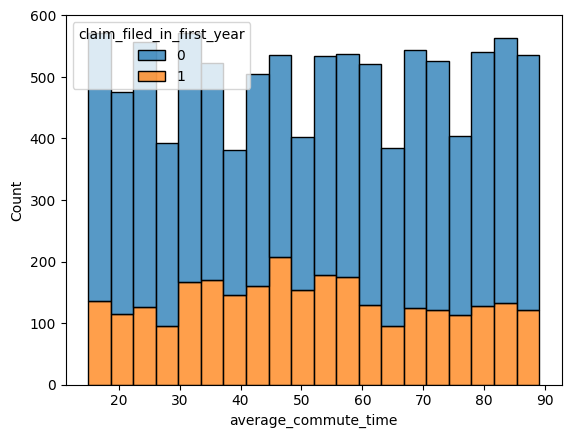

In [62]:
sns.histplot(data,x='average_commute_time',hue=predicted_variable,multiple="stack",bins=20)

Weight has no significant impact on the target variable

<Axes: xlabel='weight', ylabel='Count'>

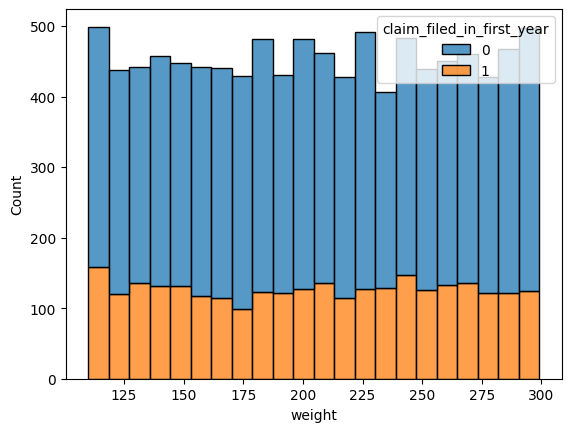

In [63]:
sns.histplot(data,x='weight',hue=predicted_variable,multiple="stack")

<Axes: xlabel='postal_code', ylabel='Count'>

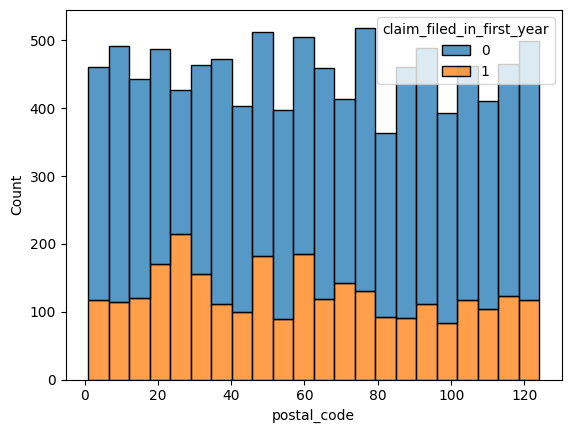

In [64]:
sns.histplot(data,x='postal_code',hue=predicted_variable,multiple="stack")

If I set the bins closer to the number of postcodes, I see there are some locations with significantly higher claims

<Axes: xlabel='postal_code', ylabel='Count'>

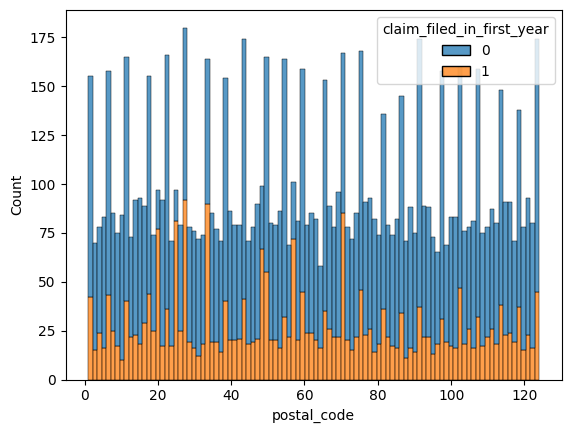

In [65]:
sns.histplot(data,x='postal_code',hue=predicted_variable,multiple="stack",bins=100)

Claims are split similarly between customers who have motorcycle coverage and those who don't, so this likely would not be of value to our model

<Axes: xlabel='motorcycle', ylabel='Count'>

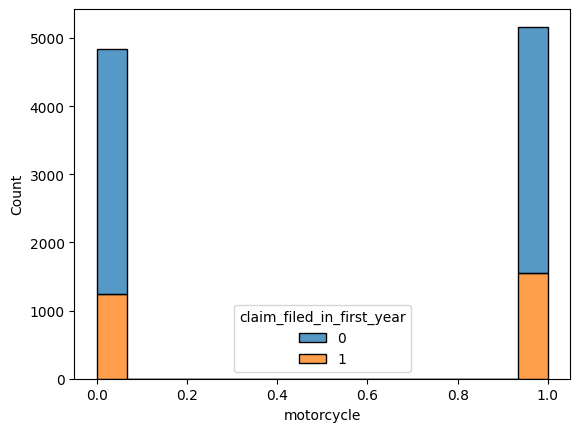

In [66]:
sns.histplot(data,x='motorcycle',hue=predicted_variable,multiple="stack")

But there are slightly more claims for customers who have had a serious driving offence

<Axes: xlabel='driving_record', ylabel='Count'>

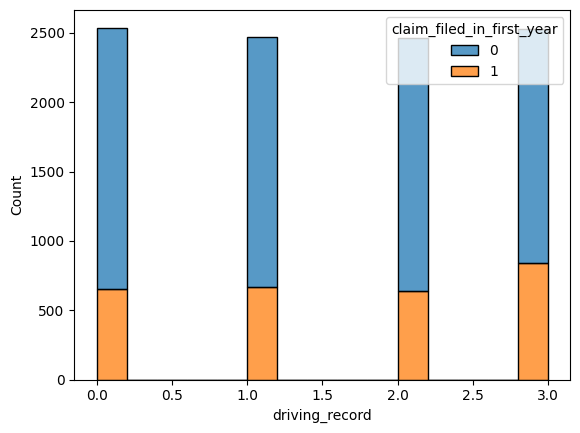

In [67]:
sns.histplot(data,x='driving_record',hue=predicted_variable,multiple="stack")

And for health status we see a similar pattern

<Axes: xlabel='health_status', ylabel='Count'>

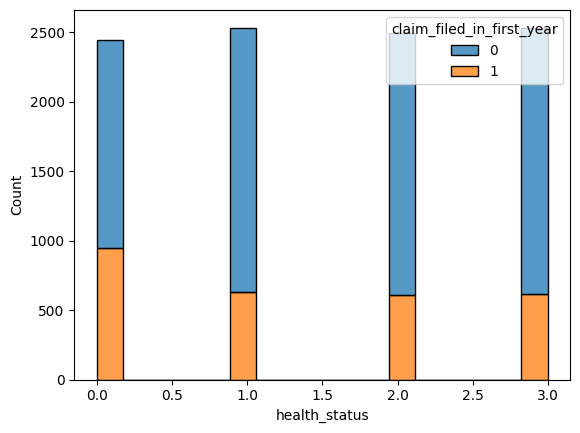

In [68]:
sns.histplot(data,x='health_status',hue=predicted_variable,multiple="stack")

## B. Preprocessing

### Encoding

To use categorical variables in our model, they should be encoded or dummified

As there were some postal codes with higher than average claims, I want to use this feature in my model, we can dummify them, meaning transform each value into it;s own feature with the value of True or False

In [69]:
pd.get_dummies(data['postal_code'])

,1,2,3,4,5,6,7,8,9,10,...,115,116,117,118,119,120,121,122,123,124
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9997,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9998,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9999,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
10000,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


But as you can see, this significantly increases our dimensionality (number of features), which would reduce our model's efficiency

Alternatively, I can engineer a new feature to just get the information I need, does the customer belong to one of the high claim postal codes or not?

In [70]:
percent_list = []
for pc in data['postal_code'].unique():
    percent_list.append([pc,(len(data[(data['postal_code']==pc)&(data[predicted_variable]==1)])/len(data[(data['postal_code']==pc)]))])

top_10_postal_codes = pd.DataFrame(percent_list,columns=['post_code','percent_claims']).sort_values(by='percent_claims',ascending=False)
top_10_postal_codes.head(10)

,post_code,percent_claims
29,25,0.835052
102,27,0.814433
94,20,0.793814
46,33,0.783505
54,71,0.783505
111,57,0.712871
42,48,0.676768
33,49,0.362637
43,19,0.337838
10,105,0.333333


The top 7 locations here have significantly more claims

In [71]:
data['high_claim_post_code'] = 0

data.loc[data['postal_code'].isin(top_10_postal_codes['post_code'].head(7).unique()),'high_claim_post_code'] =1 

In [72]:
data.high_claim_post_code.value_counts()

high_claim_post_code
0    9317
1     685
Name: count, dtype: int64

#### Based on the exploratory analysis, I selected the below features for the model

In [73]:
model_features = ['average_commute_time','debt_to_income_ratio','driving_record','high_claim_post_code','health_status']

#### Scale Data / Normalise

As different features use different scales (eg: age is 1-100, income is in the thousands, credit score is out of 850), we need to transform the data to a standard scale

Otherwise the model will give more weight to features with higher numbers, even if that feature has less importance

The scaled data will be closer to 0 but the relationships between the features are maintained

In [74]:
scaler = StandardScaler()

X_scaled =  scaler.fit_transform(data[model_features])

X_scaled

array([[-1.56658704, -1.03641623, -1.33303118, -0.27114852, -1.35445344],
       [ 1.46570538, -1.36218919, -0.44321685, -0.27114852, -0.45811605],
       [ 1.14409861, -1.50180618, -0.44321685, -0.27114852, -1.35445344],
       ...,
       [ 0.63871654,  1.0578385 ,  0.44659747, -0.27114852,  1.33455873],
       [-1.29092409, -0.75718227, -0.44321685, -0.27114852,  1.33455873],
       [ 1.23598626,  1.56976744,  1.33641179, -0.27114852, -1.35445344]],
      shape=(10002, 5))

# 3. Modelling <a id='model'></a>

## Split data into training and testing sets

A model is trained on data, but we also want the model to be good at predicting on new data.

To ensure this, we train the model on a subset of the data, usually 70% to 80%

Then once we have a trained model, we can test it on the remaining data that it has never seen.

In [75]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, data[predicted_variable], train_size=0.8,random_state=random_seed)

## Train the model

### 1. Logistic Regression

In [76]:
from sklearn.linear_model import LogisticRegression

# create the lr model
model_1 = LogisticRegression()

# train on the training data subset

model_1.fit(X_train, y_train)

# Make predictions on our test data

y_predictions = model_1.predict(X_test)

### Model Evaluation

Acknowledgement: Model performance is of no actual value here as the data has been synthesised and does not reflect any real world data, but I will explain the performance metrics

In [77]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_predictions)

print(f"Accuracy: {accuracy: .2f}")

Accuracy:  0.76


In [78]:
from sklearn.metrics import classification_report

print(classification_report(y_test,y_predictions))

              precision    recall  f1-score   support

           0       0.76      0.97      0.86      1485
           1       0.62      0.14      0.23       516

    accuracy                           0.76      2001
   macro avg       0.69      0.56      0.54      2001
weighted avg       0.73      0.76      0.69      2001



While this model appears to be 76% accurate, by looking at precision and recall we get a better idea of it's performance

Accuracy is simply how many observations from the test set the model got correct, but this does not account for the difference in observations for the target variable values

Note that for precision on predicting a claim, a 62% score indicates that out of all the customers the model **predicted** made a claim, 62% of them actually did

But recall is a better performance metric to consider. Recall shows that out of all the **actual** claims in the test set, the model got 14% of them correct

The f1-score is a balance between precision and recall

I can conclude this model is not valuable in predicting claims due to it's low recall for a positive prediction

### 2. Decision Tree

In [79]:
from sklearn.tree import DecisionTreeClassifier
import joblib
from sklearn import tree

dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)
predictions = dt_model.predict(X_test)
score = accuracy_score(y_test,predictions)
print(score)



0.6666666666666666


In [80]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.78      0.76      0.77      1485
           1       0.37      0.40      0.38       516

    accuracy                           0.67      2001
   macro avg       0.57      0.58      0.58      2001
weighted avg       0.68      0.67      0.67      2001



For our decision tree, while overall accuracy is lower, this model performs better than the logistic regression model
in terms of recall for predicting claims

A decision tree has the added benefit of being more explainable to stakeholders. As a decision tree algorithm generates a set of rules, we can follow each node to better understand how the model makes it's predictions.

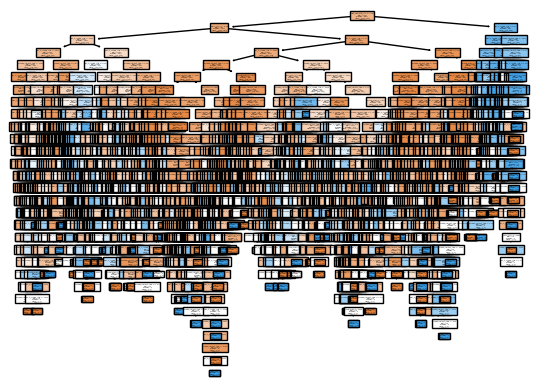

In [81]:
fig = plt.figure()
_ = tree.plot_tree(dt_model,
                   feature_names=model_features,
                   class_names=["0","1"],
                   filled=True)


# Conclusion

To achieve the goal of ensuring that only 5% of the people the business sells a policy to would claim on their policy, a model would have to have a recall score for predicting **no claim** of 95%. Then we could be confident that only 5%  of predicted non claiming customers would actually claim.

But if the recall for predicted claims is too low, the business risks not taking on too many customers who would in reality not be likely to make a claim, ultimately reducing revenue.